# Required library

In [1]:
import pandas as pd 
import scanpy as sc
import numpy as np
import torch
import random
import scvi
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import NearestNeighbors   
import statsmodels.api as sm
import torch.optim as optim
import torch.nn.functional as F
import plotly.express as px
import seaborn as sns
import math
from sklearn.decomposition import PCA
from sklearn import preprocessing

seed = 42

# Setting a fixed seed ensures reproducibility of results
# This is important for scientific work and debugging
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    scvi.settings.seed = seed 
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Set the seed to ensure reproducible results
set_seed(seed)
print(f"Global seed set to {seed}")
print("Note: To reproduce our results, please use this same seed value.")

Global seed set to 0
Global seed set to 42


Global seed set to 42
Note: To reproduce our results, please use this same seed value.


In [2]:
# Note to users about preprocessing requirements
print("\n" + "="*80)
print("IMPORTANT PREPROCESSING REQUIREMENTS:")
print("="*80)
print("Before using this notebook, please ensure both datasets are properly preprocessed:")
print("")
print("For spatial transcriptomics data:")
print("  - Filter low-quality spots (low gene count, high mitochondrial content)")
print("  - Normalize counts (e.g., using sc.pp.normalize_total)")
print("  - Log-transform data (e.g., using sc.pp.log1p)")
print("  - Store spatial coordinates in .obsm['spatial']")
print("  - Identify highly variable genes (e.g., using sc.pp.highly_variable_genes)")
print("  - Filter out mitochondria-encoded genes if needed")
print("  - batch corrections if needed")
print("")
print("For single-cell/nucleus reference data:")
print("  - Filter low-quality cells (low gene count, high mitochondrial content)")
print("  - Normalize counts (e.g., using sc.pp.normalize_total)")
print("  - Log-transform data (e.g., using sc.pp.log1p)")
print("  - Annotate cell types in .obs['celltype']")
print("  - Identify highly variable genes (e.g., using sc.pp.highly_variable_genes)")
print("  - Consider using cell2location's filter_genes() to select informative genes")
print("    that separate cell types in your reference data")
print("  - batch corrections if needed")
print("="*80)
print("")
print("IMPORTANT DATA STRUCTURE REQUIREMENTS:")
print("="*80)
print("The AnnData objects must have specific structures:")
print("  - Spatial transcriptomics data: Must have spatial coordinates in .obsm['spatial'] and .obs['annotation'] if ST has manual annotation reference")
print("  - Single-cell/nucleus reference data: Must have cell type annotations in .obs['celltype']")
print("="*80)



IMPORTANT PREPROCESSING REQUIREMENTS:
Before using this notebook, please ensure both datasets are properly preprocessed:

For spatial transcriptomics data:
  - Filter low-quality spots (low gene count, high mitochondrial content)
  - Normalize counts (e.g., using sc.pp.normalize_total)
  - Log-transform data (e.g., using sc.pp.log1p)
  - Store spatial coordinates in .obsm['spatial']
  - Identify highly variable genes (e.g., using sc.pp.highly_variable_genes)
  - Filter out mitochondria-encoded genes if needed
  - batch corrections if needed

For single-cell/nucleus reference data:
  - Filter low-quality cells (low gene count, high mitochondrial content)
  - Normalize counts (e.g., using sc.pp.normalize_total)
  - Log-transform data (e.g., using sc.pp.log1p)
  - Annotate cell types in .obs['celltype']
  - Identify highly variable genes (e.g., using sc.pp.highly_variable_genes)
  - Consider using cell2location's filter_genes() to select informative genes
    that separate cell types in 

# datasets

In [3]:
def validate_spatial_data(adata_vis):
    """
    Validate spatial transcriptomics data in AnnData format.
    
    Parameters
    ----------
    adata_vis : AnnData
        AnnData object containing spatial transcriptomics data
        
    Returns
    -------
    AnnData
        The validated AnnData object
        
    Raises
    ------
    TypeError
        If adata_vis is not an AnnData object or X is not array/sparse
    ValueError
        If X dimensions or spatial coordinates are invalid
    KeyError
        If spatial coordinates are missing
    """
    # Check if it's an AnnData object
    if not isinstance(adata_vis, sc.AnnData):
        raise TypeError("adata_vis is not an AnnData object")

    # Check if X is an array with numeric dtype
    if not isinstance(adata_vis.X, np.ndarray) and not scipy.sparse.issparse(adata_vis.X):
        raise TypeError("adata_vis.X is not an array or sparse matrix")
        
    # Check dimensions of X
    p, q = adata_vis.X.shape
    if p <= 0 or q <= 0:
        raise ValueError(f"adata_vis.X has invalid dimensions: {adata_vis.X.shape}")

    # Check if spatial is in obsm
    if 'spatial' not in adata_vis.obsm:
        raise KeyError("adata_vis.obsm does not contain 'spatial'. Please ensure your AnnData object has spatial coordinates in obsm['spatial'].")
        
    # Check if spatial is an n x 2 array
    if adata_vis.obsm['spatial'].shape[1] != 2:
        raise ValueError(f"adata_vis.obsm['spatial'] should be n x 2, but is {adata_vis.obsm['spatial'].shape}")

    # Warning about AnnData dimensions
    print("⚠️ WARNING: In AnnData, rows (obs) should be spots and columns (var) should be genes")
    print(f"adata spatial data is valid: {adata_vis.shape[0]} spots x {adata_vis.shape[1]} genes")
    
    return adata_vis

# Read and validate the dataset
# adata_vis = validate_spatial_data(sc.read_h5ad("spatial_example.h5ad"))
adata_vis = validate_spatial_data(sc.read_h5ad("adata_vis_13402.h5ad"))


def validate_reference_data(adata_ref):
    """
    Validate reference AnnData object for single-cell analysis.
    
    Parameters
    ----------
    adata_ref : AnnData
        The reference AnnData object to validate
        
    Returns
    -------
    AnnData
        The validated AnnData object
        
    Raises
    ------
    TypeError
        If adata_ref is not an AnnData object or X is not array/sparse
    ValueError
        If X dimensions are invalid
    KeyError
        If celltype annotations are missing
    """
    # Check if it's an AnnData object
    if not isinstance(adata_ref, sc.AnnData):
        raise TypeError("adata_ref is not an AnnData object")

    # Check if X is an array with numeric dtype
    if not isinstance(adata_ref.X, np.ndarray) and not scipy.sparse.issparse(adata_ref.X):
        raise TypeError("adata_ref.X is not an array or sparse matrix")
        
    # Check dimensions of X
    p, q = adata_ref.X.shape
    if p <= 0 or q <= 0:
        raise ValueError(f"adata_ref.X has invalid dimensions: {adata_ref.X.shape}")

    # Check if celltype is in obs
    if 'celltype' not in adata_ref.obs:
        raise KeyError("adata_ref.obs does not contain 'celltype'. Please ensure your AnnData object has celltype annotations.")

    # Warning about AnnData dimensions
    print("⚠️ WARNING: In AnnData, rows (obs) should be cells and columns (var) should be genes")
    print(f"adata reference data is valid: {adata_ref.shape[0]} cells x {adata_ref.shape[1]} genes")
    
    return adata_ref

# Read and validate the dataset
# adata_ref = validate_reference_data(sc.read_h5ad("reference_example.h5ad"))
adata_ref = validate_reference_data(sc.read_h5ad("adata_ref_13402.h5ad"))


# Find common genes between reference and visium datasets
common_genes = np.intersect1d(adata_ref.var.index, adata_vis.var.index)
print(f"Found {common_genes.shape[0]} common genes between reference and visium datasets")
print("These common genes will be used for downstream analysis")


⚠️ WARNING: In AnnData, rows (obs) should be spots and columns (var) should be genes
adata spatial data is valid: 428 spots x 22237 genes
⚠️ WARNING: In AnnData, rows (obs) should be cells and columns (var) should be genes
adata reference data is valid: 1926 cells x 14475 genes
Found 13402 common genes between reference and visium datasets
These common genes will be used for downstream analysis


# scvi VAE 

Global seed set to 42
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.layers[data] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(
Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision



Checking reference data:
Min value in data: 0.0
Max value in data: 7.565827369689941
Number of negative values: 0
Percentage of negative values: 0.0000%

Checking spatial data:
Min value in data: 0.0
Max value in data: 4.2196173667907715
Number of negative values: 0
Percentage of negative values: 0.0000%

Training reference model on GPU


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Epoch 1/50:   0%|          | 0/50 [00:00<?, ?it/s]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 3/50:   4%|▍         | 2/50 [00:01<00:25,  1.85it/s, loss=3.74e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 4/50:   6%|▌         | 3/50 [00:01<00:18,  2.61it/s, loss=3.49e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 6/50:  10%|█         | 5/50 [00:01<00:12,  3.71it/s, loss=3.33e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 7/50:  12%|█▏        | 6/50 [00:02<00:10,  4.18it/s, loss=3.31e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 9/50:  16%|█▌        | 8/50 [00:02<00:09,  4.65it/s, loss=3.28e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 10/50:  18%|█▊        | 9/50 [00:02<00:08,  4.78it/s, loss=3.29e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 11/50:  20%|██        | 10/50 [00:02<00:08,  4.87it/s, loss=3.28e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 12/50:  22%|██▏       | 11/50 [00:02<00:07,  4.91it/s, loss=3.28e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 14/50:  26%|██▌       | 13/50 [00:03<00:07,  5.20it/s, loss=3.25e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 15/50:  28%|██▊       | 14/50 [00:03<00:06,  5.23it/s, loss=3.25e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 16/50:  30%|███       | 15/50 [00:03<00:06,  5.18it/s, loss=3.25e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 17/50:  32%|███▏      | 16/50 [00:03<00:06,  5.14it/s, loss=3.26e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 19/50:  36%|███▌      | 18/50 [00:04<00:06,  5.12it/s, loss=3.23e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 20/50:  38%|███▊      | 19/50 [00:04<00:06,  5.10it/s, loss=3.22e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 21/50:  40%|████      | 20/50 [00:04<00:05,  5.09it/s, loss=3.23e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 22/50:  42%|████▏     | 21/50 [00:04<00:05,  5.20it/s, loss=3.23e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 24/50:  46%|████▌     | 23/50 [00:05<00:04,  5.57it/s, loss=3.22e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 26/50:  50%|█████     | 25/50 [00:05<00:04,  5.71it/s, loss=3.2e+03, v_num=1] 

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 27/50:  52%|█████▏    | 26/50 [00:05<00:04,  5.72it/s, loss=3.21e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 29/50:  56%|█████▌    | 28/50 [00:06<00:03,  5.93it/s, loss=3.22e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 31/50:  60%|██████    | 30/50 [00:06<00:03,  6.01it/s, loss=3.2e+03, v_num=1] 

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 32/50:  62%|██████▏   | 31/50 [00:06<00:03,  6.02it/s, loss=3.21e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 34/50:  66%|██████▌   | 33/50 [00:06<00:02,  6.00it/s, loss=3.2e+03, v_num=1] 

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 36/50:  70%|███████   | 35/50 [00:07<00:02,  6.05it/s, loss=3.2e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 37/50:  72%|███████▏  | 36/50 [00:07<00:02,  6.05it/s, loss=3.21e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 39/50:  76%|███████▌  | 38/50 [00:07<00:01,  6.09it/s, loss=3.2e+03, v_num=1] 

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 41/50:  80%|████████  | 40/50 [00:08<00:01,  6.12it/s, loss=3.19e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 42/50:  82%|████████▏ | 41/50 [00:08<00:01,  6.09it/s, loss=3.18e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 44/50:  86%|████████▌ | 43/50 [00:08<00:01,  6.03it/s, loss=3.2e+03, v_num=1] 

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 46/50:  90%|█████████ | 45/50 [00:08<00:00,  5.88it/s, loss=3.18e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 47/50:  92%|█████████▏| 46/50 [00:09<00:00,  6.00it/s, loss=3.19e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 49/50:  96%|█████████▌| 48/50 [00:09<00:00,  6.03it/s, loss=3.17e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 50/50: 100%|██████████| 50/50 [00:09<00:00,  6.15it/s, loss=3.17e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [00:09<00:00,  5.15it/s, loss=3.17e+03, v_num=1]


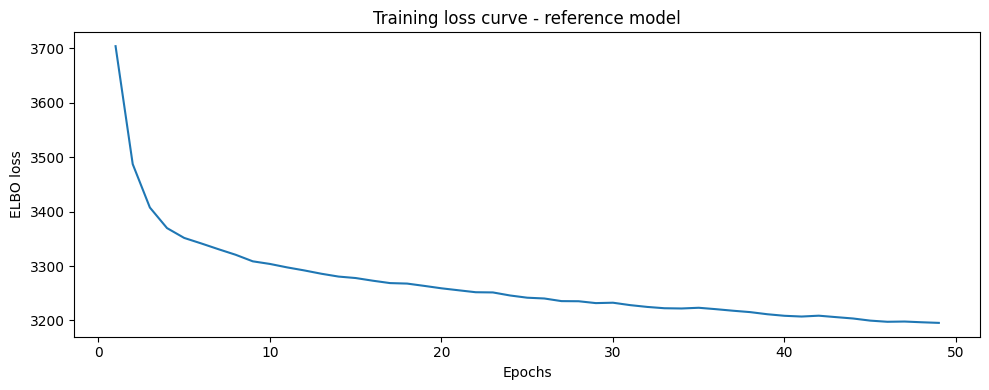

Global seed set to 42
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.layers[data] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(
Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (7) is smaller than the logging i


Training spatial model on GPU
Epoch 2/70:   1%|▏         | 1/70 [00:00<00:05, 13.55it/s, loss=2.67e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 3/70:   3%|▎         | 2/70 [00:00<00:04, 14.61it/s, loss=2.58e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 4/70:   4%|▍         | 3/70 [00:00<00:04, 14.61it/s, loss=2.48e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 6/70:   7%|▋         | 5/70 [00:00<00:04, 15.56it/s, loss=2.17e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 7/70:   9%|▊         | 6/70 [00:00<00:04, 15.46it/s, loss=2.08e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 8/70:  10%|█         | 7/70 [00:00<00:04, 15.46it/s, loss=2e+03, v_num=1]   

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 9/70:  11%|█▏        | 8/70 [00:00<00:04, 15.18it/s, loss=1.93e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 11/70:  14%|█▍        | 10/70 [00:00<00:03, 15.23it/s, loss=1.85e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 13/70:  17%|█▋        | 12/70 [00:00<00:03, 15.25it/s, loss=1.8e+03, v_num=1] 

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 15/70:  20%|██        | 14/70 [00:00<00:03, 15.36it/s, loss=1.78e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 16/70:  21%|██▏       | 15/70 [00:00<00:03, 15.36it/s, loss=1.77e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 18/70:  24%|██▍       | 17/70 [00:01<00:03, 15.15it/s, loss=1.76e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 20/70:  27%|██▋       | 19/70 [00:01<00:03, 15.31it/s, loss=1.76e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 22/70:  30%|███       | 21/70 [00:01<00:03, 15.30it/s, loss=1.74e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 24/70:  33%|███▎      | 23/70 [00:01<00:03, 15.26it/s, loss=1.73e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 25/70:  34%|███▍      | 24/70 [00:01<00:03, 15.01it/s, loss=1.73e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 27/70:  37%|███▋      | 26/70 [00:01<00:03, 14.65it/s, loss=1.72e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 28/70:  39%|███▊      | 27/70 [00:01<00:02, 14.65it/s, loss=1.72e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 30/70:  41%|████▏     | 29/70 [00:01<00:02, 14.59it/s, loss=1.72e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 31/70:  43%|████▎     | 30/70 [00:02<00:02, 14.49it/s, loss=1.71e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 33/70:  46%|████▌     | 32/70 [00:02<00:02, 14.38it/s, loss=1.71e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 34/70:  47%|████▋     | 33/70 [00:02<00:02, 14.38it/s, loss=1.7e+03, v_num=1] 

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 36/70:  51%|█████▏    | 36/70 [00:02<00:02, 14.45it/s, loss=1.7e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 38/70:  53%|█████▎    | 37/70 [00:02<00:02, 14.45it/s, loss=1.69e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 40/70:  56%|█████▌    | 39/70 [00:02<00:02, 14.72it/s, loss=1.69e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 41/70:  57%|█████▋    | 40/70 [00:02<00:02, 14.98it/s, loss=1.68e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 44/70:  61%|██████▏   | 43/70 [00:02<00:01, 14.98it/s, loss=1.68e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 45/70:  63%|██████▎   | 44/70 [00:02<00:01, 15.15it/s, loss=1.68e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 48/70:  67%|██████▋   | 47/70 [00:03<00:01, 15.15it/s, loss=1.67e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.

Epoch 51/70:  71%|███████▏  | 50/70 [00:03<00:01, 15.21it/s, loss=1.66e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 52/70:  73%|███████▎  | 51/70 [00:03<00:01, 15.21it/s, loss=1.66e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 55/70:  77%|███████▋  | 54/70 [00:03<00:01, 15.35it/s, loss=1.65e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.

Epoch 58/70:  81%|████████▏ | 57/70 [00:03<00:00, 15.34it/s, loss=1.63e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 59/70:  83%|████████▎ | 58/70 [00:03<00:00, 15.46it/s, loss=1.63e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 62/70:  87%|████████▋ | 61/70 [00:04<00:00, 15.47it/s, loss=1.63e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 65/70:  91%|█████████▏| 64/70 [00:04<00:00, 15.13it/s, loss=1.62e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 69/70:  97%|█████████▋| 68/70 [00:04<00:00, 15.04it/s, loss=1.61e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.

Epoch 70/70: 100%|██████████| 70/70 [00:04<00:00, 15.16it/s, loss=1.59e+03, v_num=1]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
`Trainer.fit` stopped: `max_epochs=70` reached.


Epoch 70/70: 100%|██████████| 70/70 [00:04<00:00, 15.05it/s, loss=1.59e+03, v_num=1]


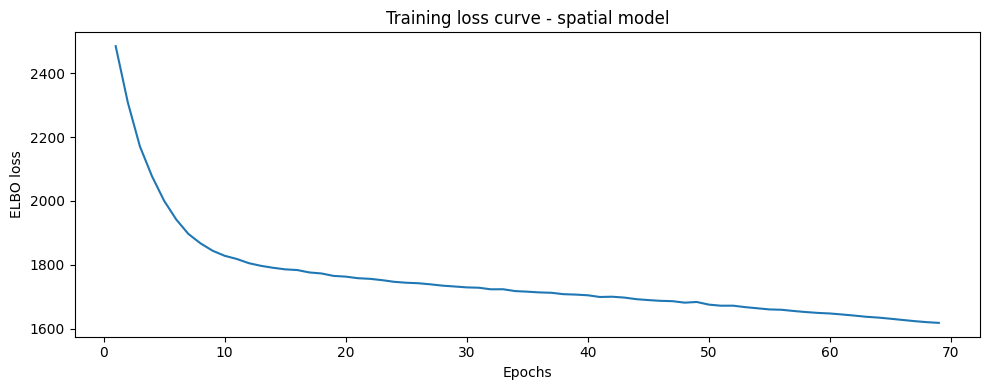

In [4]:
def prepare_data(adata_ref, adata_vis):
    """
    Prepare reference and visium data by finding common genes and handling negative values.
    
    Parameters
    ----------
    adata_ref : AnnData
        Reference single-cell dataset
    adata_vis : AnnData
        Visium spatial dataset
        
    Returns
    -------
    tuple
        Processed copies of reference and visium data
    """
    adata_ref_copy = adata_ref.copy()
    adata_vis_copy = adata_vis.copy()

    # Find common genes
    intersects = np.intersect1d(adata_ref.var.index, adata_vis.var.index)
    adata_vis_copy = adata_vis_copy[:, intersects].copy()
    adata_ref_copy = adata_ref_copy[:, intersects].copy()

    # Handle negative values in reference data
    def handle_negative_values(adata, data_name):
        min_value = np.min(adata.X)
        max_value = np.max(adata.X)
        negative_count = np.sum(adata.X < 0)
        negative_percentage = negative_count/(adata.shape[0] * adata.shape[1]) * 100

        print(f"\nChecking {data_name}:")
        print(f"Min value in data: {min_value}")
        print(f"Max value in data: {max_value}")
        print(f"Number of negative values: {negative_count}")
        print(f"Percentage of negative values: {negative_percentage:.4f}%")

        if negative_count > 0:
            print("\n⚠️ WARNING: Negative values detected in the expression matrix.")
            print("These are likely due to normalization or preprocessing steps.")
            print("Replacing all negative values with zeros to ensure compatibility with downstream analysis.")
            
            adata.X[adata.X < 0] = 0
            print(f"After replacement - Min value: {np.min(adata.X)}")
            assert np.min(adata.X) >= 0, "Failed to replace all negative values"

        adata.layers["data"] = adata.X
        return adata

    adata_ref_copy = handle_negative_values(adata_ref_copy, "reference data")
    adata_vis_copy = handle_negative_values(adata_vis_copy, "spatial data")

    return adata_ref_copy, adata_vis_copy

def train_scvi_model(adata, max_epochs=50, batch_size=128, device=None, seed=42, model_type="reference"):
    """
    Train a scVI model on the provided AnnData object.
    
    Parameters
    ----------
    adata : AnnData
        Annotated data matrix with setup already performed
    max_epochs : int, default=50
        Maximum number of training epochs
    batch_size : int, default=128
        Batch size for training
    device : int or bool, default=None
        GPU device number to use, False for CPU, None for auto-detection
    seed : int, default=42
        Random seed for reproducibility
    model_type : str, default="reference"
        Type of model to train ("reference" or "spatial")
        
    Returns
    -------
    scvi.model.SCVI
        Trained scVI model
    """
    set_seed(seed)
    
    gpu_available = torch.cuda.is_available()
    use_gpu = False
    if gpu_available:
        if device is None:
            use_gpu = True
            device_str = "GPU"
        elif device is False:
            use_gpu = False
            device_str = "CPU (forced)"
        else:
            use_gpu = True
            device_str = f"GPU (device {device})"
    else:
        device_str = "CPU (no GPU available)"

    if model_type == "reference":
        model = scvi.model.SCVI(adata,
                            n_hidden=256,
                            n_layers=3,
                            n_latent=16,
                            gene_likelihood="zinb",
                            dropout_rate=0.1,
                            latent_distribution="normal",
                            dispersion='gene-cell')
    else:
        model = scvi.model.SCVI(adata,
                            n_hidden=128,
                            n_layers=3,
                            n_latent=16,
                            gene_likelihood="zinb",
                            dropout_rate=0,
                            latent_distribution="normal")

    print(f"\nTraining {model_type} model on {device_str}")
    model.train(max_epochs=max_epochs,
                train_size=1,
                batch_size=batch_size,
                early_stopping=False,
                check_val_every_n_epoch=10,
                use_gpu=use_gpu)

    train_elbo = model.history['elbo_train'][1:]
    plt.figure(figsize=(10, 4))
    plt.plot(train_elbo)
    plt.xlabel('Epochs')
    plt.ylabel('ELBO loss')
    plt.title(f'Training loss curve - {model_type} model')
    plt.tight_layout()
    plt.show()

    return model

def get_latent_representation(model, adata):
    """
    Get latent representation from trained model and store in AnnData.
    
    Parameters
    ----------
    model : scvi.model.SCVI
        Trained scVI model
    adata : AnnData
        Data object to store latent representation
        
    Returns
    -------
    AnnData
        Data object with added latent representation
    """
    latent = model.get_latent_representation(give_mean=True, return_dist=True)
    adata.obsm['mus'] = latent[0]
    adata.obsm['var'] = latent[1]
    return adata

# Main workflow
def run_scvi_analysis(adata_ref, adata_vis, seed=42):
    """
    Run complete scVI analysis workflow.
    
    Parameters
    ----------
    adata_ref : AnnData
        Reference single-cell dataset
    adata_vis : AnnData
        Visium spatial dataset
    seed : int, default=42
        Random seed for reproducibility
        
    Returns
    -------
    tuple
        Processed reference and visium data with latent representations
    """
    # Prepare data
    adata_ref_copy, adata_vis_copy = prepare_data(adata_ref, adata_vis)
    
    # Setup and train reference model
    set_seed(seed)
    scvi.model.SCVI.setup_anndata(adata_ref_copy, layer="data", labels_key="celltype")
    model_ref = train_scvi_model(adata_ref_copy, model_type="reference", seed=seed)
    adata_ref_copy = get_latent_representation(model_ref, adata_ref_copy)
    
    set_seed(seed)
    # Setup and train visium model
    scvi.model.SCVI.setup_anndata(adata_vis_copy, layer="data")
    model_vis = train_scvi_model(adata_vis_copy, max_epochs=70, batch_size=64, model_type="spatial", seed=seed)
    adata_vis_copy = get_latent_representation(model_vis, adata_vis_copy)
    
    # Add spatial information if available
    if (adata_vis.obs_names==adata_vis_copy.obs_names).sum() == adata_vis.shape[0]:
        adata_vis_copy.obsm['spatial'] = adata_vis.obsm['spatial']
    
    return adata_ref_copy, adata_vis_copy

adata_ref_copy, adata_vis_copy = run_scvi_analysis(adata_ref, adata_vis)

# Spatial decomposition and visualizations

Global seed set to 42


it's good to go
adam_st_torch function parameters:
  regularization_option: 1 = Fastest (just Frobenius norm, no regularization)
                         2 = Simple regularization with argsort (faster)
                         3 = Sophisticated regularization with softmax (slower but potentially better)
  iteration_option:      1 = Use estimated iterations (est_iter)
                         2 = Use range-based iterations (end_range)
                         3 = Use user-defined iterations
  user_defined_iterations: Number of iterations if iteration_option is 3
  similarity_weight:     Weight for similarity loss (should be 0 for regularization_option=1)
  celltype_distance_weight: Weight for celltype distance loss (should be 0 for regularization_option=1)
Using Option 2: Simple regularization


/tmp/ipykernel_464166/2305974174.py:478: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  celltype_gene_matrix_torch = torch.tensor(celltype_gene_matrix_torch, requires_grad=False).to(device)
/tmp/ipykernel_464166/2305974174.py:379: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_sc_tensor = torch.tensor(distance_sc).cuda()
/tmp/ipykernel_464166/2305974174.py:383: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_sc = torch.tensor(torch.argsort(torch.argsort(distance_sc_tensor, dim=1), dim=1),
/tmp/ipykernel_464166/2305974174.py:262

Iteration [246000/445790], Entire Loss: 16204.1806640625, Original: 437.620849609375, Regularization 1: 15762.5, Regularization 2: 4.059999942779541
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 1.209466
         Iterations 8
McFadden's R-squared redeconve annotation: 0.0892


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [249000/445790], Entire Loss: 16132.78125, Original: 437.5071105957031, Regularization 1: 15691.2001953125, Regularization 2: 4.07450008392334
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 1.194152
         Iterations 7
McFadden's R-squared redeconve annotation: 0.1008


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [252000/445790], Entire Loss: 16056.1123046875, Original: 437.3949279785156, Regularization 1: 15614.6005859375, Regularization 2: 4.117000102996826
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 1.171464
         Iterations 7
McFadden's R-squared redeconve annotation: 0.1178


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [255000/445790], Entire Loss: 15999.8330078125, Original: 437.28448486328125, Regularization 1: 15558.400390625, Regularization 2: 4.148499965667725
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 1.136037
         Iterations 7
McFadden's R-squared redeconve annotation: 0.1445


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [258000/445790], Entire Loss: 15951.529296875, Original: 437.1756896972656, Regularization 1: 15510.2001953125, Regularization 2: 4.153500080108643
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 1.081894
         Iterations 8
McFadden's R-squared redeconve annotation: 0.1853


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [261000/445790], Entire Loss: 15899.2578125, Original: 437.0686340332031, Regularization 1: 15458.0, Regularization 2: 4.189500331878662
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 1.013060
         Iterations 8
McFadden's R-squared redeconve annotation: 0.2371


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [264000/445790], Entire Loss: 15861.1005859375, Original: 436.96319580078125, Regularization 1: 15419.900390625, Regularization 2: 4.237500190734863
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.955326
         Iterations 8
McFadden's R-squared redeconve annotation: 0.2806


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [267000/445790], Entire Loss: 15831.5380859375, Original: 436.859130859375, Regularization 1: 15390.400390625, Regularization 2: 4.278500080108643
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.925786
         Iterations 8
McFadden's R-squared redeconve annotation: 0.3028


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [270000/445790], Entire Loss: 15803.970703125, Original: 436.75628662109375, Regularization 1: 15362.900390625, Regularization 2: 4.314500331878662
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.915110
         Iterations 8
McFadden's R-squared redeconve annotation: 0.3109


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [273000/445790], Entire Loss: 15782.3896484375, Original: 436.6545715332031, Regularization 1: 15341.400390625, Regularization 2: 4.334499835968018
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.911171
         Iterations 8
McFadden's R-squared redeconve annotation: 0.3139


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [276000/445790], Entire Loss: 15756.6953125, Original: 436.55389404296875, Regularization 1: 15315.7998046875, Regularization 2: 4.3420000076293945
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.908923
         Iterations 8
McFadden's R-squared redeconve annotation: 0.3155


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [279000/445790], Entire Loss: 15738.904296875, Original: 436.4542541503906, Regularization 1: 15298.1005859375, Regularization 2: 4.3495001792907715
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.906797
         Iterations 8
McFadden's R-squared redeconve annotation: 0.3171


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [282000/445790], Entire Loss: 15740.0205078125, Original: 436.35565185546875, Regularization 1: 15299.2998046875, Regularization 2: 4.365499973297119
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.904578
         Iterations 8
McFadden's R-squared redeconve annotation: 0.3188


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [285000/445790], Entire Loss: 15729.3544921875, Original: 436.2580871582031, Regularization 1: 15288.7001953125, Regularization 2: 4.395999908447266
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.901962
         Iterations 8
McFadden's R-squared redeconve annotation: 0.3208


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [288000/445790], Entire Loss: 15721.69140625, Original: 436.16162109375, Regularization 1: 15281.1005859375, Regularization 2: 4.428500175476074
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.899240
         Iterations 8
McFadden's R-squared redeconve annotation: 0.3228


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [291000/445790], Entire Loss: 15731.61328125, Original: 436.0662536621094, Regularization 1: 15291.1005859375, Regularization 2: 4.446500301361084
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.896543
         Iterations 8
McFadden's R-squared redeconve annotation: 0.3249


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [294000/445790], Entire Loss: 15735.212890625, Original: 435.9721984863281, Regularization 1: 15294.7998046875, Regularization 2: 4.440499782562256
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.893880
         Iterations 8
McFadden's R-squared redeconve annotation: 0.3269


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [297000/445790], Entire Loss: 15737.521484375, Original: 435.879638671875, Regularization 1: 15297.2001953125, Regularization 2: 4.441499710083008
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.891339
         Iterations 8
McFadden's R-squared redeconve annotation: 0.3288


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [300000/445790], Entire Loss: 15742.7392578125, Original: 435.7886047363281, Regularization 1: 15302.5, Regularization 2: 4.450000286102295
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.888992
         Iterations 8
McFadden's R-squared redeconve annotation: 0.3306


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [303000/445790], Entire Loss: 15747.765625, Original: 435.69915771484375, Regularization 1: 15307.6005859375, Regularization 2: 4.466000080108643
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.886938
         Iterations 8
McFadden's R-squared redeconve annotation: 0.3321


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [306000/445790], Entire Loss: 15766.2861328125, Original: 435.6114807128906, Regularization 1: 15326.2001953125, Regularization 2: 4.4745001792907715
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.885411
         Iterations 8
McFadden's R-squared redeconve annotation: 0.3333


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [309000/445790], Entire Loss: 15788.900390625, Original: 435.52569580078125, Regularization 1: 15348.900390625, Regularization 2: 4.4745001792907715
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.884484
         Iterations 9
McFadden's R-squared redeconve annotation: 0.334


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [312000/445790], Entire Loss: 15811.5107421875, Original: 435.4419250488281, Regularization 1: 15371.6005859375, Regularization 2: 4.46750020980835
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.884041
         Iterations 9
McFadden's R-squared redeconve annotation: 0.3343


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [315000/445790], Entire Loss: 15831.556640625, Original: 435.3600769042969, Regularization 1: 15391.7001953125, Regularization 2: 4.495999813079834
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.883906
         Iterations 9
McFadden's R-squared redeconve annotation: 0.3344


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [318000/445790], Entire Loss: 15861.7998046875, Original: 435.2801208496094, Regularization 1: 15422.0, Regularization 2: 4.519999980926514
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.884431
         Iterations 9
McFadden's R-squared redeconve annotation: 0.334


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [321000/445790], Entire Loss: 15891.041015625, Original: 435.2021484375, Regularization 1: 15451.2998046875, Regularization 2: 4.5395002365112305
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.885422
         Iterations 9
McFadden's R-squared redeconve annotation: 0.3332


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [324000/445790], Entire Loss: 15927.6826171875, Original: 435.12628173828125, Regularization 1: 15488.0, Regularization 2: 4.557000160217285
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.886729
         Iterations 9
McFadden's R-squared redeconve annotation: 0.3323


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [327000/445790], Entire Loss: 15952.337890625, Original: 435.0528259277344, Regularization 1: 15512.7001953125, Regularization 2: 4.585000038146973
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.888247
         Iterations 10
McFadden's R-squared redeconve annotation: 0.3311


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [330000/445790], Entire Loss: 15985.78515625, Original: 434.9820251464844, Regularization 1: 15546.2001953125, Regularization 2: 4.603000164031982
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.889978
         Iterations 10
McFadden's R-squared redeconve annotation: 0.3298


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [333000/445790], Entire Loss: 16020.52734375, Original: 434.9139709472656, Regularization 1: 15581.0, Regularization 2: 4.61299991607666
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.891930
         Iterations 10
McFadden's R-squared redeconve annotation: 0.3283


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [336000/445790], Entire Loss: 16048.6533203125, Original: 434.8486633300781, Regularization 1: 15609.2001953125, Regularization 2: 4.604499816894531
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.894012
         Iterations 10
McFadden's R-squared redeconve annotation: 0.3268


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [339000/445790], Entire Loss: 16086.8994140625, Original: 434.7861022949219, Regularization 1: 15647.5, Regularization 2: 4.61299991607666
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.896190
         Iterations 10
McFadden's R-squared redeconve annotation: 0.3251


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [342000/445790], Entire Loss: 16122.1552734375, Original: 434.7262268066406, Regularization 1: 15682.7998046875, Regularization 2: 4.628499984741211
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.898503
         Iterations 10
McFadden's R-squared redeconve annotation: 0.3234


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [345000/445790], Entire Loss: 16166.1962890625, Original: 434.6683044433594, Regularization 1: 15726.900390625, Regularization 2: 4.627999782562256
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.900854
         Iterations 10
McFadden's R-squared redeconve annotation: 0.3216


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [348000/445790], Entire Loss: 16209.1572265625, Original: 434.6124267578125, Regularization 1: 15769.900390625, Regularization 2: 4.644500255584717
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.903375
         Iterations 10
McFadden's R-squared redeconve annotation: 0.3197


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [351000/445790], Entire Loss: 16240.236328125, Original: 434.5587463378906, Regularization 1: 15801.0, Regularization 2: 4.677999973297119
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.906109
         Iterations 10
McFadden's R-squared redeconve annotation: 0.3177


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [354000/445790], Entire Loss: 16278.8203125, Original: 434.5074157714844, Regularization 1: 15839.6005859375, Regularization 2: 4.7114996910095215
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.909067
         Iterations 10
McFadden's R-squared redeconve annotation: 0.3154


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [357000/445790], Entire Loss: 16307.5830078125, Original: 434.45855712890625, Regularization 1: 15868.400390625, Regularization 2: 4.7235002517700195
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.912318
         Iterations 10
McFadden's R-squared redeconve annotation: 0.313


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [360000/445790], Entire Loss: 16338.33984375, Original: 434.4122009277344, Regularization 1: 15899.2001953125, Regularization 2: 4.728000164031982
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.915555
         Iterations 10
McFadden's R-squared redeconve annotation: 0.3106


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [363000/445790], Entire Loss: 16358.6005859375, Original: 434.36822509765625, Regularization 1: 15919.5, Regularization 2: 4.73199987411499
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.918481
         Iterations 10
McFadden's R-squared redeconve annotation: 0.3083


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [366000/445790], Entire Loss: 16370.7421875, Original: 434.3262634277344, Regularization 1: 15931.7001953125, Regularization 2: 4.7154998779296875
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.921479
         Iterations 10
McFadden's R-squared redeconve annotation: 0.3061


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [369000/445790], Entire Loss: 16389.013671875, Original: 434.2863464355469, Regularization 1: 15950.0, Regularization 2: 4.727499961853027
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.924729
         Iterations 10
McFadden's R-squared redeconve annotation: 0.3036


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [372000/445790], Entire Loss: 16409.21484375, Original: 434.2485656738281, Regularization 1: 15970.2001953125, Regularization 2: 4.7669997215271
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.928118
         Iterations 10
McFadden's R-squared redeconve annotation: 0.3011


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [375000/445790], Entire Loss: 16414.099609375, Original: 434.2127380371094, Regularization 1: 15975.1005859375, Regularization 2: 4.786499977111816
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.931815
         Iterations 10
McFadden's R-squared redeconve annotation: 0.2983


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [378000/445790], Entire Loss: 16418.58984375, Original: 434.1784973144531, Regularization 1: 15979.6005859375, Regularization 2: 4.810500144958496
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.935620
         Iterations 10
McFadden's R-squared redeconve annotation: 0.2954


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [381000/445790], Entire Loss: 16417.775390625, Original: 434.14593505859375, Regularization 1: 15978.7998046875, Regularization 2: 4.829999923706055
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.939730
         Iterations 10
McFadden's R-squared redeconve annotation: 0.2923


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [384000/445790], Entire Loss: 16412.9453125, Original: 434.114990234375, Regularization 1: 15974.0, Regularization 2: 4.829999923706055
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.943998
         Iterations 10
McFadden's R-squared redeconve annotation: 0.2891


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [387000/445790], Entire Loss: 16410.115234375, Original: 434.0855407714844, Regularization 1: 15971.2001953125, Regularization 2: 4.83050012588501
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.947803
         Iterations 10
McFadden's R-squared redeconve annotation: 0.2863


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [390000/445790], Entire Loss: 16408.498046875, Original: 434.0569763183594, Regularization 1: 15969.6005859375, Regularization 2: 4.841000080108643
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.950075
         Iterations 10
McFadden's R-squared redeconve annotation: 0.2846


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [393000/445790], Entire Loss: 16403.6875, Original: 434.02880859375, Regularization 1: 15964.7998046875, Regularization 2: 4.858500003814697
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.951834
         Iterations 10
McFadden's R-squared redeconve annotation: 0.2832


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [396000/445790], Entire Loss: 16405.666015625, Original: 434.0008239746094, Regularization 1: 15966.7998046875, Regularization 2: 4.866499900817871
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.953504
         Iterations 10
McFadden's R-squared redeconve annotation: 0.282


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [399000/445790], Entire Loss: 16409.55078125, Original: 433.97314453125, Regularization 1: 15970.7001953125, Regularization 2: 4.877000331878662
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.955272
         Iterations 10
McFadden's R-squared redeconve annotation: 0.2806


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [402000/445790], Entire Loss: 16416.005859375, Original: 433.9457092285156, Regularization 1: 15977.2001953125, Regularization 2: 4.859000205993652
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.957192
         Iterations 10
McFadden's R-squared redeconve annotation: 0.2792


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [405000/445790], Entire Loss: 16413.986328125, Original: 433.9185791015625, Regularization 1: 15975.2001953125, Regularization 2: 4.867499828338623
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.959225
         Iterations 10
McFadden's R-squared redeconve annotation: 0.2777


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [408000/445790], Entire Loss: 16419.85546875, Original: 433.8916320800781, Regularization 1: 15981.1005859375, Regularization 2: 4.861999988555908
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.961182
         Iterations 10
McFadden's R-squared redeconve annotation: 0.2762


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [411000/445790], Entire Loss: 16421.833984375, Original: 433.86492919921875, Regularization 1: 15983.1005859375, Regularization 2: 4.86899995803833
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.963082
         Iterations 10
McFadden's R-squared redeconve annotation: 0.2748


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [414000/445790], Entire Loss: 16431.12109375, Original: 433.83843994140625, Regularization 1: 15992.400390625, Regularization 2: 4.882999897003174
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.964728
         Iterations 10
McFadden's R-squared redeconve annotation: 0.2735


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [417000/445790], Entire Loss: 16432.49609375, Original: 433.8121643066406, Regularization 1: 15993.7998046875, Regularization 2: 4.883500099182129
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.965850
         Iterations 10
McFadden's R-squared redeconve annotation: 0.2727


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [420000/445790], Entire Loss: 16444.35546875, Original: 433.7861328125, Regularization 1: 16005.7001953125, Regularization 2: 4.86899995803833
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.966871
         Iterations 10
McFadden's R-squared redeconve annotation: 0.2719


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [423000/445790], Entire Loss: 16453.833984375, Original: 433.76025390625, Regularization 1: 16015.2001953125, Regularization 2: 4.873000144958496
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.967941
         Iterations 10
McFadden's R-squared redeconve annotation: 0.2711


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [426000/445790], Entire Loss: 16466.21875, Original: 433.73455810546875, Regularization 1: 16027.6005859375, Regularization 2: 4.883500099182129
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.969148
         Iterations 10
McFadden's R-squared redeconve annotation: 0.2702


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [429000/445790], Entire Loss: 16476.69140625, Original: 433.708984375, Regularization 1: 16038.1005859375, Regularization 2: 4.882999897003174
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.970272
         Iterations 10
McFadden's R-squared redeconve annotation: 0.2693


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [432000/445790], Entire Loss: 16492.28515625, Original: 433.68359375, Regularization 1: 16053.7001953125, Regularization 2: 4.901500225067139
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.971245
         Iterations 10
McFadden's R-squared redeconve annotation: 0.2686


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [435000/445790], Entire Loss: 16503.046875, Original: 433.6583251953125, Regularization 1: 16064.5, Regularization 2: 4.888499736785889
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.972346
         Iterations 10
McFadden's R-squared redeconve annotation: 0.2678


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [438000/445790], Entire Loss: 16509.712890625, Original: 433.63323974609375, Regularization 1: 16071.2001953125, Regularization 2: 4.878499984741211
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.973538
         Iterations 10
McFadden's R-squared redeconve annotation: 0.2669


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [441000/445790], Entire Loss: 16514.490234375, Original: 433.6083068847656, Regularization 1: 16076.0, Regularization 2: 4.882999897003174
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.974796
         Iterations 10
McFadden's R-squared redeconve annotation: 0.2659


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Iteration [444000/445790], Entire Loss: 16528.693359375, Original: 433.5835266113281, Regularization 1: 16090.2001953125, Regularization 2: 4.908999919891357
Computing R2 score using existing 'annotation' column in spatial dataset...
This helps validate that the previously provided annotation is valid.
Optimization terminated successfully.
         Current function value: 0.976131
         Iterations 10
McFadden's R-squared redeconve annotation: 0.2649


/tmp/ipykernel_464166/2305974174.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st_tensor = torch.tensor(distance_st).cuda()
/tmp/ipykernel_464166/2305974174.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
/tmp/ipykernel_464166/2305974174.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distance_st2_tensor = torch.tensor(distance_st2).cuda()
/tmp/ipykernel_464166/2305974174.py:296: UserW

Best R2 Score: 0.3343855490565376, achieved at iteration 315000


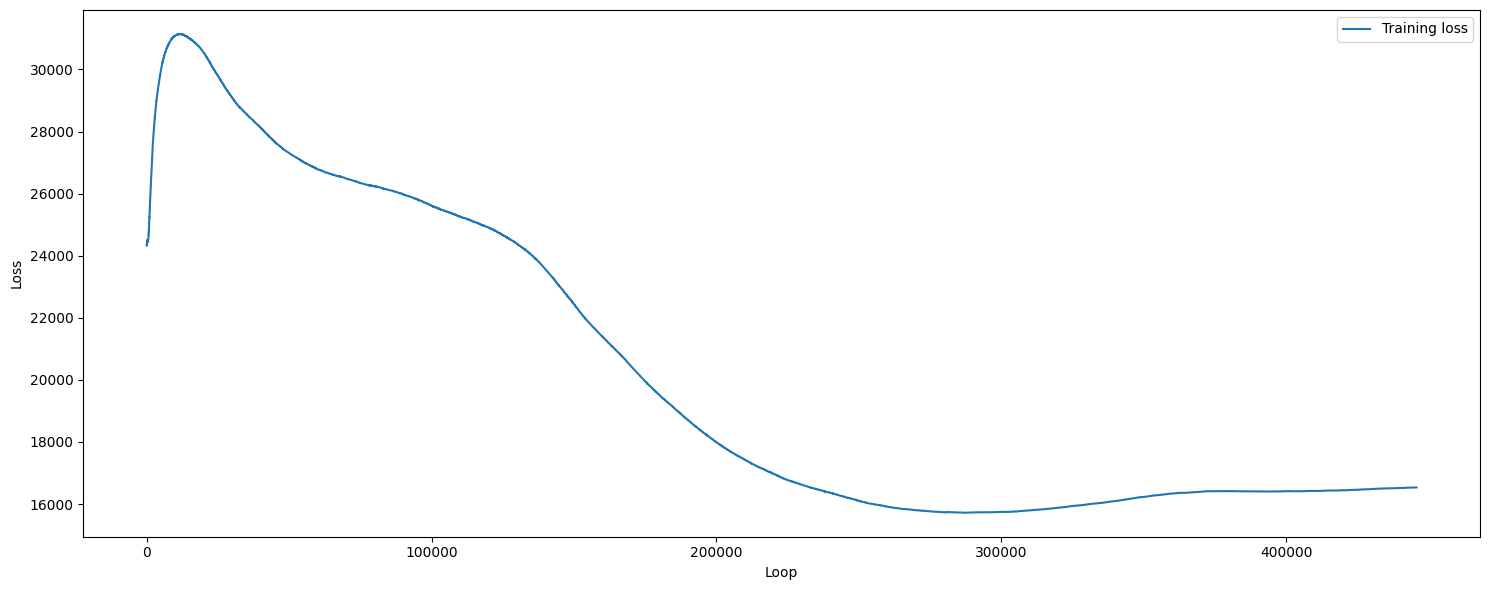

In [5]:
def plot_accuracy(train_loss):
    """
    Plot the training loss curve.
    
    Parameters:
    -----------
    train_loss : list
        List of training loss values.
    """
    num_epochs = len(train_loss)
    plt.figure(figsize=(15, 6))
    plt.plot(np.arange(1, num_epochs+1), train_loss, label='Training loss')
    plt.xlabel('Loop')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    
# Clear GPU memory
torch.cuda.empty_cache()

def calculate_celltype_embeddings(adata_ref_copy):
    """
    Calculate cell type embeddings based on mean values.
    
    Parameters:
    -----------
    adata_ref_copy : AnnData
        Reference dataset with cell type annotations.
        
    Returns:
    --------
    tuple: (celltype_emb_mean, distance_sc, celltype_gene_matrix_torch)
    """
    # Calculate cell type embeddings based on latent representation means
    celltype_emb_mean = []
    for celltype_i in adata_ref_copy.obs['celltype'].cat.categories:
        celltype_emb_mean.append(list(np.mean(adata_ref_copy.obsm['mus'][adata_ref_copy.obs['celltype'] == celltype_i], axis=0)))
    celltype_emb_mean = np.array(celltype_emb_mean)
    
    # Calculate distance matrix between cell types
    distance_sc = squareform(pdist(celltype_emb_mean, 'euclidean'))
    distance_sc = torch.tensor(distance_sc, dtype=torch.float)
    
    # Alternative cell type embedding based on gene expression (faster)
    x = []
    for celltype_i in adata_ref_copy.obs['celltype'].cat.categories:
        x.append(np.mean(adata_ref_copy.X[adata_ref_copy.obs['celltype'] == celltype_i], axis=0))
    celltype_gene_matrix_torch = np.vstack(x)
    celltype_gene_matrix_torch = torch.Tensor(celltype_gene_matrix_torch)
    if torch.cuda.is_available():
        celltype_gene_matrix_torch = celltype_gene_matrix_torch.cuda()
        
    return celltype_emb_mean, distance_sc, celltype_gene_matrix_torch

# Calculate cell type embeddings
celltype_emb_mean, distance_sc, celltype_gene_matrix_torch = calculate_celltype_embeddings(adata_ref_copy)

def find_spatial_neighbors(adata_vis_copy, k=5):
    """
    Find spatial neighbors for each spot.
    
    Parameters:
    -----------
    adata_vis_copy : AnnData
        Spatial dataset.
    k : int
        Number of neighbors to find.
        
    Returns:
    --------
    numpy.ndarray: Indices of neighbors for each spot.
    """
    N = adata_vis_copy.obsm['spatial'].shape[0]
    X = adata_vis_copy.obsm['spatial']
    
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto', metric='euclidean').fit(X)
    distances, indices = nbrs.kneighbors(X)
    return indices.copy()

# Find spatial neighbors
neighbors = find_spatial_neighbors(adata_vis_copy, k=5)

def estimate_iterations(adata_vis_copy, adata_ref_copy):
    """
    Estimate the number of iterations needed for optimization.
    
    Parameters:
    -----------
    adata_vis_copy : AnnData
        Spatial dataset.
    adata_ref_copy : AnnData
        Reference dataset.
        
    Returns:
    --------
    int: Estimated number of iterations.
    """
    est_iter = (50 * adata_vis_copy.shape[0] + 10 * adata_vis_copy.shape[1] - 
                5 * adata_ref_copy.shape[0] + 10000 * len(adata_ref_copy.obs['celltype'].cat.categories))
    
    if est_iter > 50000:
        print("it's good to go")  # make sure the number of iterations is at least 50000
    else:
        est_iter = 100000
        
    if est_iter > 100000:
        start_range = est_iter - 100000
        end_range = est_iter + 100000
    else:
        start_range = 0
        end_range = 250000
        
    return est_iter, start_range, end_range

# Estimate iterations
est_iter, start_range, end_range = estimate_iterations(adata_vis_copy, adata_ref_copy)



def compute_r2(st_approx_adam_torch):
    """
    Compute R2 score to validate deconvolution results.
    
    Parameters:
    -----------
    st_approx_adam_torch : torch.Tensor
        Deconvolved spot-cell type matrix.
        
    Returns:
    --------
    float: McFadden's R-squared value.
    """
    # Check if 'annotation' is available in the spatial dataset
    if 'annotation' not in adata_vis.obs.columns:
        print("Warning: 'annotation' column not found in spatial dataset. Cannot compute R2 score.")
        return None
    
    print("Computing R2 score using existing 'annotation' column in spatial dataset...")
    print("This helps validate that the previously provided annotation is valid.")
    
    pca = PCA(n_components=1)
    pca.fit(st_approx_adam_torch.T)

    # Get the first principal component (PC1)
    PC1 = pca.components_[0]

    le = preprocessing.LabelEncoder()
    label_entire = le.fit_transform(list(adata_vis.obs['annotation']))
    X = PC1
    model = sm.MNLogit(label_entire, sm.add_constant(X)).fit()
    mine_entire_redeannot_mcfadden_r2 = model.prsquared
    print("McFadden's R-squared redeconve annotation:", round(mine_entire_redeannot_mcfadden_r2, 4))
    return mine_entire_redeannot_mcfadden_r2

set_seed(seed)

def softmax_rank(x):
    """
    Calculate soft ranks using softmax transformation.
    
    Parameters:
    -----------
    x : torch.Tensor
        Input tensor.
        
    Returns:
    --------
    torch.Tensor: Soft ranks.
    """
    # Normalize input by maximum value
    x_shifted = x / x.max(dim=-1, keepdim=True).values
    # Apply exponential transformation with large base for sharper distinctions
    exp_x = torch.pow(1024, x_shifted)
    # Apply softmax to get probability distribution
    soft_ranks = exp_x / exp_x.sum(dim=-1, keepdim=True)
    # Scale by input dimension
    return x.shape[1] * soft_ranks

def set_optimization_options(regularization_option=1, iteration_option=3, user_defined_iterations=None, 
                            similarity_weight=0.0, celltype_distance_weight=0.0):
    """
    Set optimization options for the deconvolution process.
    
    Parameters:
    -----------
    regularization_option : int (1, 2, or 3)
        Option 1: Fastest (just Frobenius norm, no regularization)
        Option 2: Simple regularization with argsort (faster)
        Option 3: Sophisticated regularization with softmax (slower but potentially better)
    
    iteration_option : int (1, 2, or 3)
        Option 1: Use estimated iterations (est_iter)
        Option 2: Use range-based iterations (end_range)
        Option 3: Use user-defined iterations
    
    user_defined_iterations : int
        Number of iterations if iteration_option is 3
        
    similarity_weight : float
        Weight for similarity loss (should be 0 for regularization_option=1)
        
    celltype_distance_weight : float
        Weight for celltype distance loss (should be 0 for regularization_option=1)
    
    Returns:
    --------
    dict: Dictionary containing all optimization options
    """
    # If regularization_option is 1, force weights to be 0
    if regularization_option == 1:
        similarity_weight = 0.0
        celltype_distance_weight = 0.0
    
    return {
        'regularization_option': regularization_option,
        'iteration_option': iteration_option,
        'user_defined_iterations': user_defined_iterations if user_defined_iterations else 250000,
        'similarity_weight': similarity_weight,
        'celltype_distance_weight': celltype_distance_weight
    }

def custom_loss(A, B, C, D, iteration, similarity_weight, celltype_distance_weight, regularization_option, ranks_sc=None):
    """
    Custom loss function for deconvolution optimization.
    
    Parameters:
    -----------
    A : torch.Tensor
        Spatial transcriptomics data.
    B : torch.Tensor
        Spatial transcriptomics embeddings.
    C : torch.Tensor
        Spot-celltype matrix (to be optimized).
    D : torch.Tensor
        Celltype-gene matrix.
    iteration : int
        Current iteration.
    similarity_weight : float
        Weight for similarity loss.
    celltype_distance_weight : float
        Weight for celltype distance loss.
    regularization_option : int
        Regularization option (1, 2, or 3).
    ranks_sc : torch.Tensor
        Cell type distance ranks.
        
    Returns:
    --------
    tuple: (total_loss, BC, celltype_distance_loss, similarity_loss, frobenius_loss)
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Calculate ranks_st and celltype_distance_loss based on regularization_option
    if regularization_option == 1:
        # Option 1: Skip ranks_st calculation entirely for fastest computation
        ranks_st = None
        celltype_distance_loss = torch.tensor(0.0, device=device)
    elif regularization_option == 2:
        # Option 2: Simple regularization with argsort
        distance_st = torch.norm(C.T.float()[:,None] - C.T.float(), dim=2, p=2)
        if torch.cuda.is_available():
            distance_st_tensor = torch.tensor(distance_st).cuda()
        else:
            distance_st_tensor = torch.tensor(distance_st)
            
        ranks_st = torch.tensor(torch.argsort(torch.argsort(distance_st_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
        celltype_distance_loss = F.mse_loss(ranks_sc.float(), ranks_st.float())
    elif regularization_option == 3:
        # Option 3: Sophisticated regularization with softmax_rank
        distance_st = torch.norm(C.T.float()[:,None] - C.T.float(), dim=2, p=2)
        if torch.cuda.is_available():
            ranks_st = softmax_rank(distance_st.cuda())
        else:
            ranks_st = softmax_rank(torch.tensor(distance_st))
        celltype_distance_loss = F.mse_loss(ranks_sc.float(), ranks_st.float())
    
    BC = torch.mm(B, C)
    
    base = 1.001 
    BC = torch.pow(base, BC) / torch.max(torch.pow(base, BC))
    
    predicted_A = torch.mm(BC, D)
    
    # Calculate similarity_loss based on regularization_option
    if regularization_option == 1:
        # Option 1: Skip similarity_loss calculation entirely
        similarity_loss = torch.tensor(0.0, device=device)
    elif regularization_option == 2:
        # Option 2: Simple regularization with argsort
        distance_st2 = torch.norm(BC.float()[:,None] - BC.float(), dim=2, p=2)
        if torch.cuda.is_available():
            distance_st2_tensor = torch.tensor(distance_st2).cuda()
        else:
            distance_st2_tensor = torch.tensor(distance_st2)
            
        rankings = torch.tensor(torch.argsort(torch.argsort(distance_st2_tensor, dim=1), dim=1), dtype=torch.float, requires_grad=True)
        similarity_loss = torch.sum(rankings[np.arange(len(neighbors))[:, None], neighbors])
    elif regularization_option == 3:
        # Option 3: Sophisticated regularization with softmax_rank
        distance_st2 = torch.norm(BC.float()[:,None] - BC.float(), dim=2, p=2)
        if torch.cuda.is_available():
            rankings = softmax_rank(distance_st2.cuda())
        else:
            rankings = softmax_rank(distance_st2)
        similarity_loss = torch.sum(rankings[np.arange(len(neighbors))[:, None], neighbors])
    
    fro_loss = torch.linalg.norm(A - predicted_A, 'fro')
    
    loss = (similarity_weight * similarity_loss) + (celltype_distance_weight * celltype_distance_loss) + fro_loss
    return loss, BC, celltype_distance_weight * celltype_distance_loss, similarity_weight * similarity_loss, fro_loss

train_loss_st_torch = []
def adam_st_torch(st, st_emb, spot_celltype, celltype_gene, 
                regularization_option=1, 
                iteration_option=3, 
                user_defined_iterations=None, 
                similarity_weight=0.0, 
                celltype_distance_weight=0.0):
    """
    Perform deconvolution using Adam optimizer with customizable optimization options.
    
    Parameters:
    -----------
    st : torch.Tensor
        Spatial transcriptomics data
    st_emb : torch.Tensor
        Spatial transcriptomics embeddings
    spot_celltype : torch.Tensor
        Spot-celltype matrix (to be optimized)
    celltype_gene : torch.Tensor
        Celltype-gene matrix
    regularization_option : int (1, 2, or 3)
        Option 1: Fastest (just Frobenius norm, no regularization)
        Option 2: Simple regularization with argsort (faster)
        Option 3: Sophisticated regularization with softmax (slower but potentially better)
    iteration_option : int (1, 2, or 3)
        Option 1: Use estimated iterations (est_iter)
        Option 2: Use range-based iterations (end_range)
        Option 3: Use user-defined iterations
    user_defined_iterations : int
        Number of iterations if iteration_option is 3
    similarity_weight : float
        Weight for similarity loss
    celltype_distance_weight : float
        Weight for celltype distance loss
    
    Returns:
    --------
    tuple: (st_approx_adam_torch, best_iteration)
    """
    # Check if CUDA is available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Create optimization options from parameters
    opt_options = set_optimization_options(
        regularization_option=regularization_option,
        iteration_option=iteration_option,
        user_defined_iterations=user_defined_iterations,
        similarity_weight=similarity_weight,
        celltype_distance_weight=celltype_distance_weight
    )
    
    # Extract options
    regularization_option = opt_options['regularization_option']
    iteration_option = opt_options['iteration_option']
    user_defined_iterations = opt_options['user_defined_iterations']
    similarity_weight = opt_options['similarity_weight']
    celltype_distance_weight = opt_options['celltype_distance_weight']

    # Process based on selected option
    if regularization_option == 1:
        # Option 1: Skip ranks_sc calculation entirely for fastest computation
        ranks_sc = None  # Will not be used in loss function
        print("Using Option 1: Fastest computation (Frobenius norm only)")
    elif regularization_option == 2:
        # Option 2: Simple regularization with argsort
        print("Using Option 2: Simple regularization")
        if torch.cuda.is_available():
            distance_sc_tensor = torch.tensor(distance_sc).cuda()
        else:
            distance_sc_tensor = torch.tensor(distance_sc)
        
        ranks_sc = torch.tensor(torch.argsort(torch.argsort(distance_sc_tensor, dim=1), dim=1), 
                            dtype=torch.float, requires_grad=True)
    elif regularization_option == 3:
        # Option 3: Sophisticated regularization with softmax_rank
        print("Using Option 3: Sophisticated regularization (slower)")
        if torch.cuda.is_available():
            ranks_sc = softmax_rank(distance_sc.cuda())
        else:
            distance_sc_tensor = torch.tensor(distance_sc)
            ranks_sc = softmax_rank(distance_sc_tensor)
        
    # Choose an optimization algorithm (e.g., Adam) and set hyperparameters
    learning_rate = 0.001
    optimizer = optim.Adam([spot_celltype], lr=learning_rate)
    
    # Set the number of training iterations based on iteration_option
    if iteration_option == 1:
        num_iterations = est_iter
    elif iteration_option == 2:
        num_iterations = end_range
    elif iteration_option == 3:
        num_iterations = user_defined_iterations
    else:
        # Default to end_range if option is invalid
        num_iterations = 250000

    prev_loss = float('inf')
    prev_celltypedist_loss = float('inf')
    best_r2 = 0
    best_iteration = 0
    
    for iteration in range(num_iterations):
        # Compute the loss
        loss, BC, celltypedistloss, similarityloss, froloss = custom_loss(st, st_emb, spot_celltype, celltype_gene, iteration, 
                                                                        similarity_weight, celltype_distance_weight, regularization_option, ranks_sc)
            
        # Perform backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # Update C using the optimizer
        optimizer.step()

        prev_celltypedist_loss = celltypedistloss.item()
        
        prev_loss = loss.item()
        train_loss_st_torch.append(loss.item())
        # Print the loss at regular intervals
        if (iteration + 1) % 3000 == 0:
            # Only print once for each interval
            if iteration_option != 2:
                print(f"Iteration [{iteration + 1}/{num_iterations}], Entire Loss: {loss.item()}, Original: {froloss.item()}, Regularization 1: {similarityloss.item()}, Regularization 2: {celltypedistloss.item()}")
            
            # For iteration_option 2, compute R2 and track best performance
            if iteration_option == 2 and start_range <= iteration <= end_range:
                print(f"Iteration [{iteration + 1}/{num_iterations}], Entire Loss: {loss.item()}, Original: {froloss.item()}, Regularization 1: {similarityloss.item()}, Regularization 2: {celltypedistloss.item()}")
                
                # Compute R2 and update best model if improved
                r2 = compute_r2(BC.detach().cpu().numpy())
                if r2 > best_r2:
                    best_r2 = r2
                    best_iteration = iteration + 1
                    st_approx_adam_torch = BC
    if iteration_option == 1 or iteration_option == 3:          
        st_approx_adam_torch = BC
    
    # Print the best R2 score and its corresponding iteration only for iteration_option 2
    if iteration_option == 2:
        print(f"Best R2 Score: {best_r2}, achieved at iteration {best_iteration}")
    return st_approx_adam_torch, best_iteration

def setup_deconvolution(adata_vis_copy, adata_ref_copy):
    """
    Set up tensors for deconvolution.
    
    Parameters:
    -----------
    adata_vis_copy : AnnData
        Spatial dataset.
    adata_ref_copy : AnnData
        Reference dataset.
        
    Returns:
    --------
    tuple: (st, st_emb, spot_celltype, celltype_gene_matrix_torch)
    """
    torch.set_printoptions(precision=8)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    st = torch.tensor(adata_vis_copy.X.copy(), requires_grad=False).to(device)
    st_emb = torch.tensor(adata_vis_copy.obsm['mus'], requires_grad=False).to(device)
    spot_celltype = torch.randn(st_emb.shape[1], adata_ref_copy.obs['celltype'].cat.categories.shape[0], requires_grad=True, device=device)
    
    
    _, _, celltype_gene_matrix_torch = calculate_celltype_embeddings(adata_ref_copy)
    celltype_gene_matrix_torch = torch.tensor(celltype_gene_matrix_torch, requires_grad=False).to(device)
    
    return st, st_emb, spot_celltype, celltype_gene_matrix_torch

# Set up tensors for deconvolution
st, st_emb, spot_celltype, celltype_gene_matrix_torch = setup_deconvolution(adata_vis_copy, adata_ref_copy)

# Print instructions for adam_st_torch parameters
print("adam_st_torch function parameters:")
print("  regularization_option: 1 = Fastest (just Frobenius norm, no regularization)")
print("                         2 = Simple regularization with argsort (faster)")
print("                         3 = Sophisticated regularization with softmax (slower but potentially better)")
print("  iteration_option:      1 = Use estimated iterations (est_iter)")
print("                         2 = Use range-based iterations (end_range)")
print("                         3 = Use user-defined iterations")
print("  user_defined_iterations: Number of iterations if iteration_option is 3")
print("  similarity_weight:     Weight for similarity loss (should be 0 for regularization_option=1)")
print("  celltype_distance_weight: Weight for celltype distance loss (should be 0 for regularization_option=1)")

def run_deconvolution(st, st_emb, spot_celltype, celltype_gene_matrix_torch, 
                    regularization_option=1, iteration_option=3, 
                    user_defined_iterations=250000, similarity_weight=0.1, 
                    celltype_distance_weight=0.1):
    """
    Run deconvolution using adam_st_torch and process results.
    
    Parameters
    ----------
    st : torch.Tensor
        Spatial transcriptomics data tensor
    st_emb : torch.Tensor 
        Spatial embeddings tensor
    spot_celltype : torch.Tensor
        Initial spot-celltype tensor
    celltype_gene_matrix_torch : torch.Tensor
        Celltype-gene matrix tensor
    regularization_option : int, optional
        Regularization option (1-3), by default 1
    iteration_option : int, optional 
        Iteration option (1-3), by default 3
    user_defined_iterations : int, optional
        Number of iterations if iteration_option=3, by default 250000
    similarity_weight : float, optional
        Weight for similarity loss, by default 0.1
    celltype_distance_weight : float, optional
        Weight for celltype distance loss, by default 0.1
        
    Returns
    -------
    tuple
        (spot_celltype AnnData object, st_approx_adam_torch array)
    """
    # Run deconvolution
    st_approx_adam_torch, bestiteration = adam_st_torch(st, st_emb, spot_celltype, celltype_gene_matrix_torch,
                                                    regularization_option=regularization_option,
                                                    iteration_option=iteration_option,
                                                    user_defined_iterations=user_defined_iterations,
                                                    similarity_weight=similarity_weight,
                                                    celltype_distance_weight=celltype_distance_weight)
    st_approx_adam_torch = st_approx_adam_torch.detach().cpu().numpy()

    torch.cuda.empty_cache()

    plot_accuracy(train_loss_st_torch)

    st_approx_adam_torch_original = st_approx_adam_torch.copy()
    st_approx_adam_torch = st_approx_adam_torch / st_approx_adam_torch.sum(axis=1, keepdims=True)

    spot_celltype = sc.AnnData(st_approx_adam_torch)
    
    return spot_celltype, st_approx_adam_torch

# Run the deconvolution function
spot_celltype, st_approx_adam_torch = run_deconvolution(st, st_emb, spot_celltype, celltype_gene_matrix_torch,
                                                    regularization_option=2,
                                                    iteration_option=2,
                                                    user_defined_iterations=320000,
                                                    similarity_weight=0.1,
                                                    celltype_distance_weight=0.1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


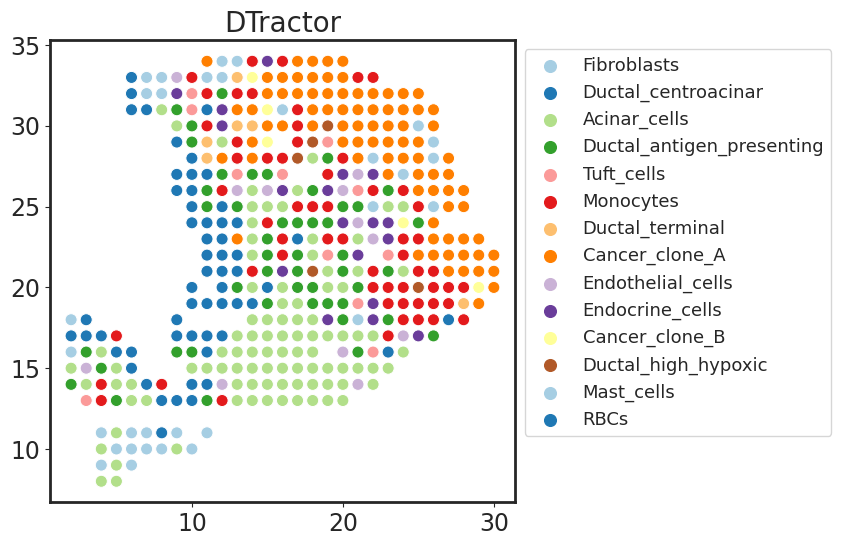

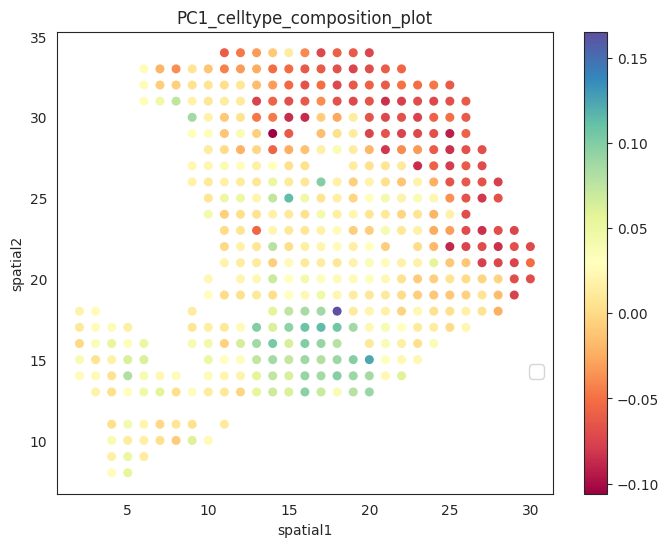

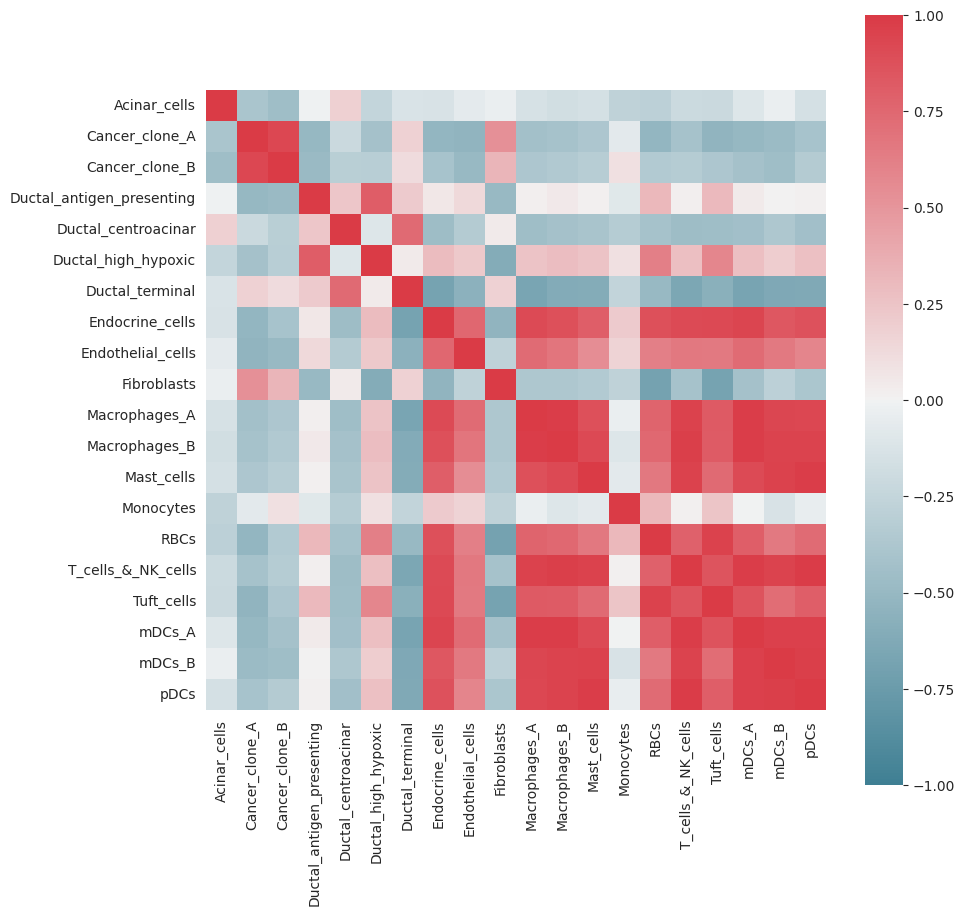

In [7]:
def plot_spatial_celltype_predictions(spot_celltype, adata_vis_copy, st_approx_adam_torch, adata_ref_copy):
    """
    Plot spatial distribution of predicted cell types.
    
    Parameters
    ----------
    spot_celltype : AnnData
        AnnData object containing spot-celltype information
    adata_vis_copy : AnnData
        AnnData object containing spatial data
    st_approx_adam_torch : np.ndarray
        Spot x cell type proportion matrix
    adata_ref_copy : AnnData
        Reference AnnData object containing cell type categories
        
    Returns
    -------
    None
    """
    # Add spatial coordinates
    spot_celltype.obsm['lat'] = adata_vis_copy.obsm['spatial'][:,0]
    spot_celltype.obsm['lon'] = adata_vis_copy.obsm['spatial'][:,1]
    
    if 'annotation' in adata_vis_copy.obs:
        spot_celltype.obs['annotation'] = list(adata_vis_copy.obs['annotation'])

    # Get most likely cell type for each spot
    ind = [] 
    for row in st_approx_adam_torch:
        max_col_pos = np.argmax(row)
        ind.append(max_col_pos)
    most_likely_celltype = []
    for elem in ind:
        pred = adata_ref_copy.obs['celltype'].cat.categories[elem]
        most_likely_celltype.append(pred)
    spot_celltype.obs["celltype_pred"] = most_likely_celltype

    # Create plot
    plt.figure(figsize=(6, 6))
    sns.set_style("white")
    sns.despine(trim=False)
    plt.tick_params(axis='both', which='major', labelsize=17, bottom=True, left=True)
    
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(2)
        
    sns.scatterplot(x=spot_celltype.obsm['lat'], 
                    y=spot_celltype.obsm['lon'], 
                    hue=spot_celltype.obs["celltype_pred"], 
                    palette='Paired', 
                    s=75)
    plt.title('DTractor', fontsize=20)
    plt.legend(loc='upper right', bbox_to_anchor=(1.7, 1), fontsize=13, markerscale=1.4)
    plt.grid(False)

def plot_pc1_spatial(spot_celltype, st_approx_adam_torch):
    """
    Plot first principal component of cell type composition in spatial coordinates.
    
    Parameters
    ----------
    spot_celltype : AnnData
        AnnData object containing spatial coordinates
    st_approx_adam_torch : np.ndarray
        Spot x cell type proportion matrix
        
    Returns
    -------
    None
    """
    pca = PCA(n_components=1)
    pca.fit(st_approx_adam_torch.T)
    PC1 = pca.components_[0]
    plt.figure(figsize=(8, 6))
    s = plt.scatter(spot_celltype.obsm['lat'], 
                spot_celltype.obsm['lon'], 
                c=PC1, 
                cmap='Spectral', 
                s=30)
    plt.xlabel('spatial1')
    plt.ylabel('spatial2')
    plt.title('PC1_celltype_composition_plot')
    plt.legend(loc='upper right', bbox_to_anchor=(1, 0.3), fontsize=13)
    plt.colorbar(s)

def plot_celltype_correlation(st_approx_adam_torch, adata_ref_copy):
    """
    Plot correlation heatmap between cell types.
    
    Parameters
    ----------
    st_approx_adam_torch : np.ndarray
        Spot x cell type proportion matrix
    adata_ref_copy : AnnData
        Reference AnnData object containing cell type categories
        
    Returns
    -------
    None
    """
    f, ax = plt.subplots(figsize=(10, 10))
    corr = pd.DataFrame(st_approx_adam_torch).set_axis(adata_ref_copy.obs['celltype'].cat.categories, axis=1).corr()
    sns.heatmap(corr,
                cmap=sns.diverging_palette(220, 10, as_cmap=True),
                vmin=-1.0, 
                vmax=1.0,
                square=True, 
                ax=ax)

# Run the visualization functions
plot_spatial_celltype_predictions(spot_celltype, adata_vis_copy, st_approx_adam_torch, adata_ref_copy)
plot_pc1_spatial(spot_celltype, st_approx_adam_torch) 
plot_celltype_correlation(st_approx_adam_torch, adata_ref_copy)
